# Gold and Silver Ratio

### Overview
In this notebook, I will try to replicate the analysis performed by Belangp on his precious metal trading/stacking strategy based on the gold and silver ratio.

### Reference
- GSR Valuation Update Time to Favor Silver (https://www.youtube.com/watch?v=C2EGjhcW-a0)

In [94]:
# Import libraries
import pandas as pd
import quandl
import math
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
from scipy.stats import linregress
import os
%matplotlib notebook

# Set up folder directories
input_dir = "01_Raw_Data/"
procs_dir = "02_Processed_Data/"
output_dir = "03_Output_Data/"

In [11]:
start_date = "1900-01-01"
end_date = "2020-08-25"

## 1. Prepare Price Data from Quandl
We are gonna leverage Quandl's free precious metal data for this analysis. Only run this module for periodic refresh as data are saved in the `\02_Processed_Data` folder.

#### Download Price Data for LBMA Gold
Uncomment the codes below to refresh the data.

In [14]:
# lbma_gold_df = quandl.get("LBMA/GOLD", authtoken="mph6fTrjas2wX3sBdYQn", start_date=start_date, end_date=end_date)
# lbma_gold_df['LBMA_Gold_USD'] = (lbma_gold_df['USD (AM)'] + lbma_gold_df['USD (PM)']) *0.5
# lbma_gold_df.index = pd.to_datetime(lbma_gold_df.index)
# pd.DataFrame(lbma_gold_df['LBMA_Gold_USD']).to_csv(procs_dir + 'lbma_gold_usd.csv')

#### Download Price Data for LBMA Silver
Uncomment the codes below to refresh the data.

In [13]:
# lbma_silver_df = quandl.get("LBMA/SILVER", authtoken="mph6fTrjas2wX3sBdYQn", start_date=start_date, end_date=end_date)
# lbma_silver_df.index = pd.to_datetime(lbma_silver_df.index)
# lbma_silver_df['LBMA_Silver_USD'] = lbma_silver_df['USD']
# pd.DataFrame(lbma_silver_df['LBMA_Silver_USD']).to_csv(procs_dir + 'lbma_silver_usd.csv')

#### Preprocess G&S Data
I append the downloaded gold and silver price data so that they're in the same dataframe.

In [213]:
# Read the downloaded data
lbma_gold_usd = pd.read_csv(procs_dir + 'lbma_gold_usd.csv', index_col=0, parse_dates=True)
lbma_silver_usd = pd.read_csv(procs_dir + 'lbma_silver_usd.csv', index_col=0, parse_dates=True)

# Resample to month-end (daily/weekly data will likely be too noisy)
lbma_gold_usd = lbma_gold_usd.resample('M').median() #last()
lbma_silver_usd = lbma_silver_usd.resample('M').median() #last()

# Append the gold and silver data
gs_comb_df = lbma_gold_usd.merge(lbma_silver_usd, how='outer', left_index=True, right_index=True)
gs_comb_df = gs_comb_df.dropna(how='any')

# Calculate Gold and Silver Ratio (GSR)
gs_comb_df['GSR'] = gs_comb_df['LBMA_Gold_USD'].divide(gs_comb_df['LBMA_Silver_USD'])

In [214]:
gs_comb_df.head()

,LBMA_Gold_USD,LBMA_Silver_USD,GSR
Date,,,
1968-04-30,37.875,2.256,16.788564
1968-05-31,41.050,2.416,16.990894
1968-06-30,41.075,2.478,16.575868
1968-07-31,39.175,2.331,16.806092
1968-08-31,39.100,2.213,17.668324


Good stuff. We have data available from 30/04/1968 for both gold and silver.

# 2. Calculate Periodic Return
For this analysis, we look at the horizon of every 10 years. For a rotational window of 10 years, we are going to do the following:
- Calculate percentage return individually for gold and silver
- Calculate the return of silver relative to gold
- Append the GSR as at the **beginning** of each observation window

Since the data has been resampled to monthly, we will calculate the return every 120 months (i.e. 10 years).

In [215]:
# Calculate individual percentage return
gs_return_df = gs_comb_df[['LBMA_Gold_USD', 'LBMA_Silver_USD']].pct_change(periods=120).dropna()
gs_return_df.columns = ['return_gold', 'return_silver']

# Calculate silver return relative to gold 
gs_return_df['return_rel'] = gs_return_df['return_silver'] - gs_return_df['return_gold']

In [216]:
gs_return_df.head()

,return_gold,return_silver,return_rel
Date,,,
1978-04-30,3.660726,1.296099,-2.364627
1978-05-31,3.298417,1.117136,-2.181281
1978-06-30,3.479306,1.150928,-2.328378
1978-07-31,3.747926,1.273273,-2.474653
1978-08-31,4.274616,1.501808,-2.772809


Now for each 10 years' return of gold and silver, we need to append the GSR at the beginning of each observation window. Take, for instance, a 10-year observation window from **30/04/1968** to **30/04/1978** (inclusive):
- Gold YoY return = 335.87%, silver YoY return = 108.51%, relative YoY return = -227.36%
- GSR = 16.31 as at 30/04/1968

Note that the GSR on 30/04/1968, instead of 30/04/1978, is used here.

In [217]:
# Shift the column by 120 months backward, so that the GSR at the beginning of the 10-year observation window
# will be mapped to the observation window end date
gs_return_df['GSR_start'] = gs_comb_df['GSR'].shift(periods=120)
gs_return_df.head()

,return_gold,return_silver,return_rel,GSR_start
Date,,,,
1978-04-30,3.660726,1.296099,-2.364627,16.788564
1978-05-31,3.298417,1.117136,-2.181281,16.990894
1978-06-30,3.479306,1.150928,-2.328378,16.575868
1978-07-31,3.747926,1.273273,-2.474653,16.806092
1978-08-31,4.274616,1.501808,-2.772809,17.668324


# 3. Perform Regression Analysis
Our data is now prepared and handsome, so we may proceed with our actual analysis.
## 3.1. Initial Attempt

In [218]:
# Filter on the data (<= 2018-03-26)
# gs_return_df1 = gs_return_df.loc[gs_return_df.index <= "2018-02-01"]
gs_return_df1 = gs_return_df

In [219]:
# Here x is GSR and y is the relative return
x1 = gs_return_df1['GSR_start']
y1 = gs_return_df1['return_rel']

# Fit the linear regression
lr1 = linregress(x1, y1)
print(lr1)
print("\nR-squared: %.2f%%\nGSR cut-off: %.2f" % (100*lr1.rvalue**2, -lr1.intercept/lr1.slope))

LinregressResult(slope=0.04651496818309515, intercept=-2.968917915596102, rvalue=0.6369862413451662, pvalue=2.784634584737444e-59, stderr=0.0025000158042978995)

R-squared: 40.58%
GSR cut-off: 63.83


In [220]:
# Plot the points and fitted line
plt.figure()
plt.plot(x, y, 'o', markersize=2)
plt.plot(x, lr.slope * x + lr.intercept)
plt.show()

<IPython.core.display.Javascript object>

Interestingly, we are not able to get the results as provided in the video, which is:

%Return = 0.1654 \* (GSR - 64.1) = -10.602 + 0.1654 \* GSR, with RSQ = 82%

While the line is not exactly the same, the fitted intercept with the x-axis of 63.77% is pretty close to the advised value.

## 3.2. Second Attempt

In this attempt, I will apply a percentile filter to take out the extreme (1%) observations from both ends.

In [211]:
# Take out observations within 1% of either tails
filt_alpha = 0.05
filt_cond = ( gs_return_df.return_rel <= np.percentile(gs_return_df.return_rel, (1-filt_alpha)*100) ) &\
            ( gs_return_df.return_rel >= np.percentile(gs_return_df.return_rel, filt_alpha*100))
gs_return_df2 = gs_return_df[filt_cond]
gs_return_df2.shape

# Here x is GSR and y is the relative return
x2 = gs_return_df2['GSR_start']
y2 = gs_return_df2['return_rel']

# Fit the linear regression
lr2 = linregress(x2,y2)
print(lr2)
print("\nR-squared: %.2f%%, p-value: %.5f\nGSR cut-off: %.2f" %\
      (100*lr2.rvalue**2, lr2.pvalue, -lr2.intercept/lr2.slope))

LinregressResult(slope=0.027869234774241733, intercept=-1.8704728529922177, rvalue=0.7784032456451703, pvalue=4.7690041748170254e-94, stderr=0.001053686768315907)

R-squared: 60.59%, p-value: 0.00000
GSR cut-off: 67.12


<IPython.core.display.Javascript object>


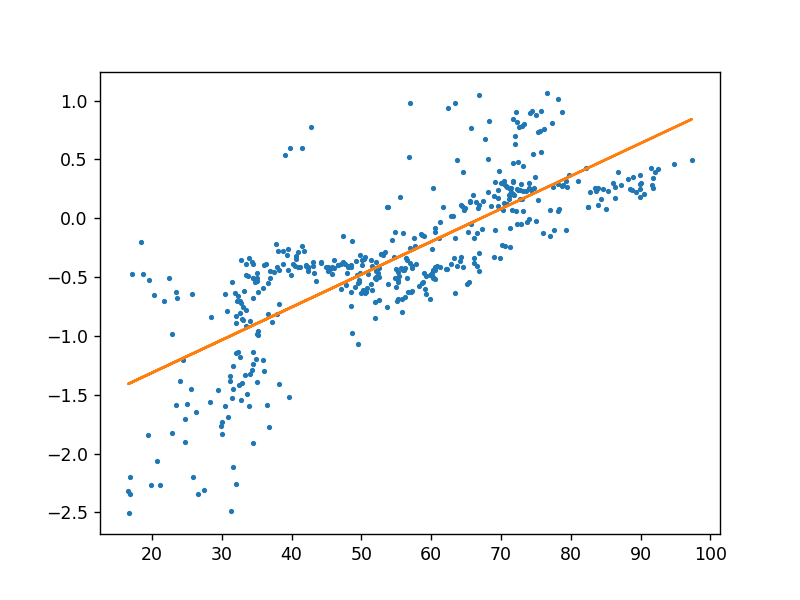

In [212]:
# Plot the points and fitted line
plt.figure()
plt.plot(x2, y2, 'o', markersize=2)
plt.plot(x2, lr2.slope * x2 + lr2.intercept)
plt.show()